In [1]:
import torch
from transformers import AutoProcessor, AutoModelForImageTextToText, BitsAndBytesConfig

import requests
from PIL import Image as PILImage
import io, os

In [2]:
# System message for the assistant
system_message = "You are an expert product description writer for Amazon."

# User prompt that combines the user query and the schema
user_prompt = """Create a Short Product description based on the provided <PRODUCT> and <CATEGORY> and image.
Only return description. The description should be SEO optimized and for a better mobile search experience.

<PRODUCT>
{product}
</PRODUCT>

<CATEGORY>
{category}
</CATEGORY>
"""

In [3]:
def hf_img_to_pil(img_dict):
    """
    HF Image feature -> PIL.Image
    """
    # 1) bytes가 있으면 바로
    if img_dict.get("bytes") is not None:
        return PILImage.open(io.BytesIO(img_dict["bytes"]))
    # 2) path가 있으면 경로에서 로드
    if img_dict.get("path") is not None and os.path.exists(img_dict["path"]):
        return PILImage.open(img_dict["path"])
    return None  # 둘 다 없으면 실패

In [4]:
def process_vision_info(messages):
    # 하나의 conversation 데이터에 있는 list of dict를 처리
    imgs = []
    for msg in messages:                       # message = {'role':..., 'content': [...]}
        for elem in msg.get("content", []):    # elem = dict
            # ① 이미지 타입인지 필터
            if elem.get("type") != "image":
                continue
            img_obj = elem.get("image")
            # ② 실제 이미지 객체가 있는지 확인
            if img_obj is None:
                continue
            # ③ HF Image dict → PIL 변환
            if isinstance(img_obj, dict):
                img_obj = hf_img_to_pil(img_obj)
            if isinstance(img_obj, PILImage.Image):
                imgs.append(img_obj.convert("RGB"))
    return imgs


In [5]:
output_dir = '/purestorage/AILAB/AI_1/tyk/3_CUProjects/language_model/VLM/gemma3/finetune_amz_product/merged_model'
# Load Model with PEFT adapter
model = AutoModelForImageTextToText.from_pretrained(
  output_dir,
  device_map="auto",
  torch_dtype=torch.bfloat16,
  attn_implementation="eager",
)
processor = AutoProcessor.from_pretrained(output_dir)

Loading checkpoint shards:   0%|          | 0/10 [00:00<?, ?it/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [6]:
# Test sample with Product Name, Category and Image
sample = {
  "product_name": "Hasbro Marvel Avengers-Serie Marvel Assemble Titan-Held, Iron Man, 30,5 cm Actionfigur",
  "category": "Toys & Games | Toy Figures & Playsets | Action Figures",
  "image": PILImage.open(requests.get("https://m.media-amazon.com/images/I/81+7Up7IWyL._AC_SY300_SX300_.jpg", stream=True).raw).convert("RGB")
}

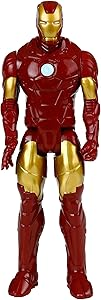

In [7]:
sample['image']

In [8]:
def generate_description(sample, model, processor):
    # Convert sample into messages and then apply the chat template
    messages = [
        {"role": "system", "content": [{"type": "text", "text": system_message}]},
        {"role": "user", "content": [
            {"type": "image","image": sample["image"]},
            {"type": "text", "text": user_prompt.format(product=sample["product_name"], category=sample["category"])},
        ]},
    ]
    text = processor.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=True
    )
    # Process the image and text
    image_inputs = process_vision_info(messages)
    # Tokenize the text and process the images
    inputs = processor(
        text=[text],
        images=image_inputs,
        padding=True,
        return_tensors="pt",
    )
    # Move the inputs to the device
    inputs = inputs.to(model.device)

    # Generate the output
    stop_token_ids = [processor.tokenizer.eos_token_id, processor.tokenizer.convert_tokens_to_ids("<end_of_turn>")]
    generated_ids = model.generate(**inputs, max_new_tokens=256, top_p=1.0, do_sample=True, temperature=0.8, eos_token_id=stop_token_ids, disable_compile=True)
    # Trim the generation and decode the output to text
    generated_ids_trimmed = [out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)]
    output_text = processor.batch_decode(
        generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
    )
    return output_text[0]

In [9]:
messages = [
        {"role": "system", "content": [{"type": "text", "text": system_message}]},
        {"role": "user", "content": [
            {"type": "image","image": sample["image"]},
            {"type": "text", "text": user_prompt.format(product=sample["product_name"], category=sample["category"])},
        ]},
    ]

In [ ]:
text = processor.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=True # assistant turn을 넣어주기 위해
    )

In [11]:
text

'<bos><start_of_turn>user\nYou are an expert product description writer for Amazon.\n\n<start_of_image>Create a Short Product description based on the provided <PRODUCT> and <CATEGORY> and image.\nOnly return description. The description should be SEO optimized and for a better mobile search experience.\n\n<PRODUCT>\nHasbro Marvel Avengers-Serie Marvel Assemble Titan-Held, Iron Man, 30,5 cm Actionfigur\n</PRODUCT>\n\n<CATEGORY>\nToys & Games | Toy Figures & Playsets | Action Figures\n</CATEGORY><end_of_turn>\n<start_of_turn>model\n'

In [12]:
# Process the image and text
image_inputs = process_vision_info(messages)

In [14]:
image_inputs

[<PIL.Image.Image image mode=RGB size=101x300>]

In [15]:
# Tokenize the text and process the images
inputs = processor(
    text=[text],
    images=image_inputs,
    padding=True,
    return_tensors="pt",
)

In [19]:
type(inputs)

transformers.feature_extraction_utils.BatchFeature

In [21]:
inputs["input_ids"][0]  

tensor([     2,      2,    105,   2364,    107,   3048,    659,    614,   7710,
          1698,   6492,  11456,    573,   9593, 236761,    110, 255999, 262144,
        262144, 262144, 262144, 262144, 262144, 262144, 262144, 262144, 262144,
        262144, 262144, 262144, 262144, 262144, 262144, 262144, 262144, 262144,
        262144, 262144, 262144, 262144, 262144, 262144, 262144, 262144, 262144,
        262144, 262144, 262144, 262144, 262144, 262144, 262144, 262144, 262144,
        262144, 262144, 262144, 262144, 262144, 262144, 262144, 262144, 262144,
        262144, 262144, 262144, 262144, 262144, 262144, 262144, 262144, 262144,
        262144, 262144, 262144, 262144, 262144, 262144, 262144, 262144, 262144,
        262144, 262144, 262144, 262144, 262144, 262144, 262144, 262144, 262144,
        262144, 262144, 262144, 262144, 262144, 262144, 262144, 262144, 262144,
        262144, 262144, 262144, 262144, 262144, 262144, 262144, 262144, 262144,
        262144, 262144, 262144, 262144, 

In [24]:
decode_text = processor.tokenizer.decode(
    inputs["input_ids"][0],                 # 또는 sample.tolist()
    skip_special_tokens=True    # <pad>, <bos>, <eos> 등 제거
)
print(decode_text)

user
You are an expert product description writer for Amazon.





Create a Short Product description based on the provided <PRODUCT> and <CATEGORY> and image.
Only return description. The description should be SEO optimized and for a better mobile search experience.

<PRODUCT>
Hasbro Marvel Avengers-Serie Marvel Assemble Titan-Held, Iron Man, 30,5 cm Actionfigur
</PRODUCT>

<CATEGORY>
Toys & Games | Toy Figures & Playsets | Action Figures
</CATEGORY>
model



In [25]:
text

'<bos><start_of_turn>user\nYou are an expert product description writer for Amazon.\n\n<start_of_image>Create a Short Product description based on the provided <PRODUCT> and <CATEGORY> and image.\nOnly return description. The description should be SEO optimized and for a better mobile search experience.\n\n<PRODUCT>\nHasbro Marvel Avengers-Serie Marvel Assemble Titan-Held, Iron Man, 30,5 cm Actionfigur\n</PRODUCT>\n\n<CATEGORY>\nToys & Games | Toy Figures & Playsets | Action Figures\n</CATEGORY><end_of_turn>\n<start_of_turn>model\n'

In [26]:
# Generate the output
stop_token_ids = [processor.tokenizer.eos_token_id, processor.tokenizer.convert_tokens_to_ids("<end_of_turn>")]

In [27]:
stop_token_ids

[1, 106]

In [31]:
inputs["input_ids"][0].device

device(type='cpu')

In [32]:
inputs = inputs.to(model.device)

In [33]:
generated_ids = model.generate(**inputs, max_new_tokens=256, top_p=1.0, do_sample=True, temperature=0.8, eos_token_id=stop_token_ids, disable_compile=True)

In [34]:
generated_ids

tensor([[     2,      2,    105,   2364,    107,   3048,    659,    614,   7710,
           1698,   6492,  11456,    573,   9593, 236761,    110, 255999, 262144,
         262144, 262144, 262144, 262144, 262144, 262144, 262144, 262144, 262144,
         262144, 262144, 262144, 262144, 262144, 262144, 262144, 262144, 262144,
         262144, 262144, 262144, 262144, 262144, 262144, 262144, 262144, 262144,
         262144, 262144, 262144, 262144, 262144, 262144, 262144, 262144, 262144,
         262144, 262144, 262144, 262144, 262144, 262144, 262144, 262144, 262144,
         262144, 262144, 262144, 262144, 262144, 262144, 262144, 262144, 262144,
         262144, 262144, 262144, 262144, 262144, 262144, 262144, 262144, 262144,
         262144, 262144, 262144, 262144, 262144, 262144, 262144, 262144, 262144,
         262144, 262144, 262144, 262144, 262144, 262144, 262144, 262144, 262144,
         262144, 262144, 262144, 262144, 262144, 262144, 262144, 262144, 262144,
         262144, 262144, 262

In [ ]:
for in_ids, out_ids in zip(inputs.input_ids, generated_ids):
    #print(in_ids, out_ids)
    print(len(in_ids))
    print(len(out_ids))

# 371 번째 부터 아웃풋이 들어가야함

371
451


In [41]:
# Trim the generation and decode the output to text
generated_ids_trimmed = [out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)]

In [44]:
out_ids

tensor([     2,      2,    105,   2364,    107,   3048,    659,    614,   7710,
          1698,   6492,  11456,    573,   9593, 236761,    110, 255999, 262144,
        262144, 262144, 262144, 262144, 262144, 262144, 262144, 262144, 262144,
        262144, 262144, 262144, 262144, 262144, 262144, 262144, 262144, 262144,
        262144, 262144, 262144, 262144, 262144, 262144, 262144, 262144, 262144,
        262144, 262144, 262144, 262144, 262144, 262144, 262144, 262144, 262144,
        262144, 262144, 262144, 262144, 262144, 262144, 262144, 262144, 262144,
        262144, 262144, 262144, 262144, 262144, 262144, 262144, 262144, 262144,
        262144, 262144, 262144, 262144, 262144, 262144, 262144, 262144, 262144,
        262144, 262144, 262144, 262144, 262144, 262144, 262144, 262144, 262144,
        262144, 262144, 262144, 262144, 262144, 262144, 262144, 262144, 262144,
        262144, 262144, 262144, 262144, 262144, 262144, 262144, 262144, 262144,
        262144, 262144, 262144, 262144, 

In [43]:
generated_ids_trimmed

[tensor([114484,    506, 224857,  30313,  79131, 236772, 127198,  30313, 155486,
          39406, 236772, 122004,  21444,   2599,  10659,  75010, 236888,   1174,
         236743, 236800, 236771, 236761, 236810,   3696, 236772,  98599, 116235,
            563,    912,    529,    506,  30313, 155486,  39406, 236772, 122004,
          37539,    532,    563,   4011,    573,  49646,    532,   7807,  27432,
         236761,    138,   3497,  21179,   4889,    532,  15978,  83918, 236764,
            672,  21444,   2599,   5811,    563,    496,   1921, 236772,  17777,
            573,   1027,  30313,  81536, 236761,    138,   3218,   1515,    531,
            822, 191792, 236789, 236751,   5249,   3124, 236888,    106],
        device='cuda:0')]

In [ ]:
len(generated_ids_trimmed[0])

80

In [45]:
output_text = processor.batch_decode(
        generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
    )

In [46]:
output_text

["Introducing the Hasbro Marvel Avengers-Serie Marvel Assemble Titan-Held Iron Man Actionfigur! This 30.5cm-tall figurine is part of the Marvel Assemble Titan-Held lineup and is perfect for collectors and fans alike.  With realistic details and impressive craftsmanship, this Iron Man figure is a must-have for any Marvel enthusiast.  Add him to your Avenger's collection today!"]

In [ ]:
def generate_description(sample, model, processor):
    # Convert sample into messages and then apply the chat template
    messages = [
        {"role": "system", "content": [{"type": "text", "text": system_message}]},
        {"role": "user", "content": [
            {"type": "image","image": sample["image"]},
            {"type": "text", "text": user_prompt.format(product=sample["product_name"], category=sample["category"])},
        ]},
    ]
    text = processor.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=True
    )
    # Process the image and text
    image_inputs = process_vision_info(messages)
    # Tokenize the text and process the images
    inputs = processor(
        text=[text],
        images=image_inputs,
        padding=True,
        return_tensors="pt",
    )
    # Move the inputs to the device
    inputs = inputs.to(model.device)

    # Generate the output
    stop_token_ids = [processor.tokenizer.eos_token_id, processor.tokenizer.convert_tokens_to_ids("<end_of_turn>")]
    generated_ids = model.generate(**inputs, max_new_tokens=256, top_p=1.0, do_sample=True, temperature=0.8, eos_token_id=stop_token_ids, disable_compile=True)
    # Trim the generation and decode the output to text
    generated_ids_trimmed = [out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)]
    output_text = processor.batch_decode(
        generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
    )
    return output_text[0]